[10/30] train loss: 0.27, valid loss: 0.39
[20/30] train loss: 0.20, valid loss: 0.26
[30/30] train loss: 0.17, valid loss: 0.21


0.18163644

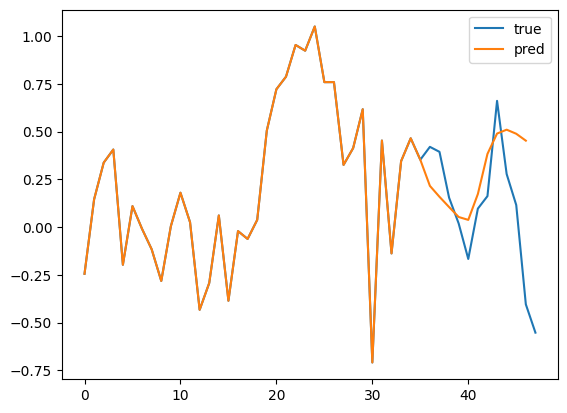

In [9]:

#【PyTorch】Transformerによる時系列予測
#Library

#ライブラリのインポート
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

#ランダムシードの設定
fix_seed = 2023
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

#デバイスの設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#データのロードと実験用の整形

class AirPassengersDataset(Dataset):
    def __init__(self, flag, seq_len, pred_len):
        #学習期間と予測期間の設定
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        #訓練用、評価用、テスト用を分けるためのフラグ
        type_map = {'train': 0, 'val': 1, 'test':2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        
        #seabornのデータセットから飛行機の搭乗者数のデータをロード
        #df_raw = pd.read_csv('flights_hand.csv')
        df_raw = pd.read_csv('hand_300.csv')

        #訓練用、評価用、テスト用で呼び出すデータを変える
        border1s = [0, 12 * 9 - self.seq_len, 12 * 11 - self.seq_len]
        border2s = [12 * 9, 12 * 11, 12 * 12]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        data = df_raw[['8_z']].values
        ss = StandardScaler()
        data = ss.fit_transform(data)

        self.data = data[border1:border2]

    def __getitem__(self, index):
        #学習用の系列と予測用の系列を出力
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        src = self.data[s_begin:s_end]
        tgt = self.data[r_begin:r_end]

        return src, tgt
    
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

#DataLoaderの定義

def data_provider(flag, seq_len, pred_len, batch_size):
    #flagに合ったデータを出力
    data_set = AirPassengersDataset(flag=flag, 
                                    seq_len=seq_len, 
                                    pred_len=pred_len
                                   )
    #データをバッチごとに分けて出力できるDataLoaderを使用
    data_loader = DataLoader(data_set,
                             batch_size=batch_size, 
                             shuffle=True
                            )
    
    return data_loader

#エンべディングの定義

#位置エンコーディングの定義
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

#モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model) 

    def forward(self, x):
        x = self.tokenConv(x)
        return x

#Transformerの定義

class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers,
        d_model, d_input, d_output,
        dim_feedforward = 512, dropout = 0.1, nhead = 8):
        
        super(Transformer, self).__init__()
        

        #エンべディングの定義
        self.token_embedding_src = TokenEmbedding(d_input, d_model)
        self.token_embedding_tgt = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        #エンコーダの定義
        encoder_layer = TransformerEncoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, 
                                                      num_layers=num_encoder_layers,
                                                      norm=encoder_norm
                                                     )
        
        #デコーダの定義
        decoder_layer = TransformerDecoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, 
                                                      num_layers=num_decoder_layers, 
                                                      norm=decoder_norm)
        
        #出力層の定義
        self.output = nn.Linear(d_model, d_output)
        

    def forward(self, src, tgt, mask_src, mask_tgt):
        #mask_src, mask_tgtはセルフアテンションの際に未来のデータにアテンションを向けないためのマスク
        
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory = self.transformer_encoder(embedding_src, mask_src)
        
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(embedding_tgt, memory, mask_tgt)
        
        output = self.output(outs)
        return output

    def encode(self, src, mask_src):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt, memory, mask_tgt):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

#マスクの定義

def create_mask(src, tgt):
    
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask

#訓練、評価の処理を定義

def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)

        mask_src, mask_tgt = create_mask(src, input_tgt)

        output = model(
            src=src, tgt=input_tgt, 
            mask_src=mask_src, mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
        
    return np.average(total_loss)


def evaluate(flag, model, data_provider, criterion):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)
    
        memory = model.encode(src, mask_src)
        outputs = src[:, -1:, :]
        seq_len_tgt = tgt.shape[1]
    
        for i in range(seq_len_tgt - 1):
        
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)
        
            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)

            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
        
        loss = criterion(outputs, tgt)
        total_loss.append(loss.cpu().detach())
        
    if flag=='test':
        true = torch.cat((src, tgt), dim=1)
        pred = torch.cat((src, output), dim=1)
        plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
        plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
        plt.legend()
        plt.savefig('test.pdf')
        
    return np.average(total_loss)

#パラメータなどの定義

d_input = 1
d_output = 1
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.01
src_len = 36
tgt_len = 12
batch_size = 1
epochs = 30
best_loss = float('Inf')
best_model = None

model = Transformer(num_encoder_layers=num_encoder_layers,
                    num_decoder_layers=num_decoder_layers,
                    d_model=d_model,
                    d_input=d_input, 
                    d_output=d_output,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout, nhead=nhead
                   )

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)

#訓練と評価用データにおける評価

valid_losses = []
for epoch in range(1, epochs + 1):
    
    loss_train = train(
        model=model, data_provider=data_provider('train', src_len, tgt_len, batch_size), optimizer=optimizer,
        criterion=criterion
    )
        
    loss_valid = evaluate(
        flag='val', model=model, data_provider=data_provider('val', src_len, tgt_len, batch_size), criterion=criterion
    )
    
    if epoch%10==0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(
            epoch, epochs,
            loss_train, loss_valid,
        ))
        
    valid_losses.append(loss_valid)
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model


#テスト用データにおける予測

evaluate(flag='test', model=best_model, data_provider=data_provider('test', src_len, tgt_len, batch_size), criterion=criterion)


